In [1]:
#导入相关包
import numpy as np
import matplotlib.pyplot as plt
import random
import netCDF4
import datetime
import seaborn as sns
from global_land_mask import globe
from scipy import interpolate
from sklearn.metrics import silhouette_samples
from sklearn.preprocessing import StandardScaler
#plt.rcParams['font.sans-serif'] = ['SimHei'] #中文支持
#%matplotlib inline

In [2]:
#cor评价指标
def cor_caluate(Y_test,t_preds,index):
    cor_day = []
    a=0
    b=0
    c=0
    for i in range(0,index):
        for j in range(0,len(Y_test)):
            a+=(Y_test[j,i,:]*t_preds[j,i,:]).sum()
            b+=(Y_test[j,i]**2).sum()
            c+=(t_preds[j,i]**2).sum()
        b=np.sqrt(b)
        c=np.sqrt(c)
        cor=a/(b*c)
        cor_day.append(cor)
        a=0
        b=0
        c=0
    cor_day=np.array(cor_day)
    print(cor_day)
    return cor_day

In [3]:
#画cor指标
def cor_acc(cor_day):
    # 绘制损失函数曲线
    fig = plt.figure(figsize=(8,4))
    # subplot loss
    ax1 = fig.add_subplot(121)
    ax1.plot(cor_day, label='cor_acc')
    ax1.set_xlabel('days')
    ax1.set_ylabel('cor')
    ax1.set_title('MJO Bivariate Correlation')
    ax1.legend()
    ax1.axhline(y=0.5,color='red',linewidth=0.85)
    plt.tight_layout()

In [4]:
#rmse评价指标
def rmse_caluate(Y_test,t_preds,index):
    rmse_day = []
    a=0
    for i in range(0,index):
        for j in range(0,len(Y_test)):
            a+=((Y_test[j,i,:]-t_preds[j,i,:])**2).sum()
        rmse=a/len(Y_test)
        rmse=np.sqrt(rmse)
        rmse_day.append(rmse)
        a=0
    rmse_day=np.array(rmse_day)
    print(rmse_day)
    return rmse_day

In [5]:
#画rmse指标
def rmse_acc(rmse_day):
    # 绘制损失函数曲线
    fig = plt.figure(figsize=(8,4))
    # subplot loss
    ax1 = fig.add_subplot(121)
    ax1.plot(rmse_day, label='rmse_acc')
    ax1.set_xlabel('days')
    ax1.set_ylabel('rmse')
    ax1.set_title('MJO Bivariate Correlation')
    ax1.legend()
    ax1.axhline(y=1.4,color='red',linewidth=0.85)
    plt.tight_layout()

In [6]:
#读取文件名
babj_filename=np.loadtxt('/WdHeDisk/users/zhangnong/MJO/711_test/babj_date_sort.txt')
ecmf_filename=np.loadtxt('/WdHeDisk/users/zhangnong/MJO/711_test/ecmf_date_sort.txt')
babj_path='/WdHeDisk/users/zhangnong/MJO/711_test/s2s_RMM/babj/'
ecmf_path='/WdHeDisk/users/zhangnong/MJO/711_test/s2s_RMM/ecmf/'
babj_re_path='/WdHeDisk/users/zhangnong/MJO/711_test/re_RMM/babj/'
ecmf_re_path='/WdHeDisk/users/zhangnong/MJO/711_test/re_RMM/ecmf/'

In [10]:
def babj_create_data(filename,path,re_path):
    data1=[]
    data2=[]
    for i in range(0,len(filename)-9):
        str_name=str(int(filename[i]))
        s2s_data=np.load(path+str_name+'_babj_rmm.npy')
        re_data=np.load(re_path+str_name+'_babj_rmm.npy')
        data1.append(s2s_data)
        data2.append(re_data)
    data1=np.array(data1)
    data2=np.array(data2)
    return data1 ,data2

In [11]:
def ecmf_create_data(filename,path,re_path):
    data1=[]
    data2=[]
    for i in range(0,len(filename)-9):
        str_name=str(int(filename[i]))
        s2s_data=np.load(path+str_name+'_ecmf_rmm.npy')
        re_data=np.load(re_path+str_name+'_ecmf_rmm.npy')
        data1.append(s2s_data)
        data2.append(re_data)
    data1=np.array(data1)
    data2=np.array(data2)
    return data1 ,data2

In [12]:
babj_data,babj_re_data=babj_create_data(babj_filename,babj_path,babj_re_path)
ecmf_data,ecmf_re_data=ecmf_create_data(ecmf_filename,ecmf_path,ecmf_re_path)

In [13]:
print(babj_data.shape,babj_re_data.shape)
print(ecmf_data.shape,ecmf_re_data.shape)

(1655, 60, 2) (1655, 60, 2)
(1356, 46, 2) (1356, 46, 2)


In [14]:
print(babj_data[0:10,0,:])
print(babj_re_data[0:10,0,:])

[[-1.36049787 -0.66946282]
 [-1.1477956   0.06174321]
 [-1.42270715  0.21505572]
 [-1.07843872  1.14356405]
 [ 0.50712874  1.51684804]
 [ 1.82944851  1.35453707]
 [ 1.51356033 -0.08425935]
 [ 1.36825953 -1.01492044]
 [ 0.30067947 -1.65868863]
 [-0.40897    -1.95857025]]
[[-1.2158944  -0.19479641]
 [-0.86925316  0.69827678]
 [-1.05734522  0.77261785]
 [-0.49414729  1.57654576]
 [ 0.91504438  1.6427296 ]
 [ 2.42722385  1.21335463]
 [ 1.96864991 -0.43614994]
 [ 2.00429766 -1.08574647]
 [ 0.88597781 -1.87332613]
 [ 0.07421295 -2.26661055]]


[0.96697133 0.95715766 0.94681521 0.93591353 0.91909125 0.90113253
 0.88360428 0.85651727 0.825967   0.79706356 0.77222722 0.74203371
 0.71127805 0.68438899 0.65746858 0.6320516  0.60653069 0.58150551
 0.55922808 0.53890768 0.52072518 0.50989049 0.49663013 0.48063164
 0.46548709 0.44749673 0.43703978 0.41805372 0.4008643  0.38405836
 0.36802767 0.35773444 0.3359239  0.32559841 0.3176126  0.31031073
 0.2956884  0.28661555 0.27907373 0.26607713 0.26147376 0.25109019
 0.2493885  0.23954963 0.23225081 0.22375111 0.21318342 0.21727123
 0.20964636 0.20084533 0.20705065 0.20761285 0.21169799 0.20893415
 0.2155181  0.21726694 0.2132465  0.20967895 0.2072055  0.20717392]
[0.3575586  0.41080848 0.45121251 0.49385397 0.55174021 0.60695171
 0.65526323 0.72176493 0.78996065 0.84720759 0.89207456 0.94304326
 0.99069606 1.02675909 1.06244192 1.09502675 1.12624841 1.15624265
 1.18160712 1.20410739 1.2204215  1.2289629  1.24078456 1.25511298
 1.26980047 1.28655952 1.29538768 1.30980513 1.32190027 1.334

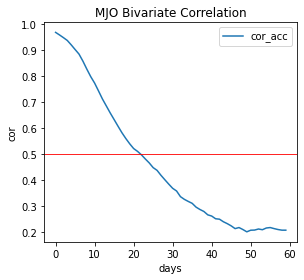

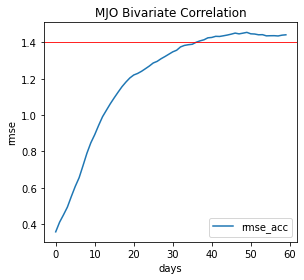

In [16]:
babj_cor_day=cor_caluate(babj_data,babj_re_data,60)
babj_rmse_day=rmse_caluate(babj_data,babj_re_data,60)
cor_acc(babj_cor_day)
rmse_acc(babj_rmse_day)

[0.98584806 0.98236441 0.97810265 0.97237174 0.96500943 0.95516534
 0.94429451 0.93012667 0.91590492 0.9010918  0.88374637 0.86666154
 0.85046869 0.83130826 0.80986285 0.78780933 0.76670502 0.74272338
 0.72246057 0.7074742  0.6872687  0.67179193 0.65381112 0.63710421
 0.61678171 0.59912873 0.58692024 0.57026075 0.55221132 0.53416583
 0.52141073 0.51141233 0.49451146 0.4766443  0.46164896 0.44750286
 0.43551201 0.41778731 0.40984472 0.39882336 0.38726    0.36881535
 0.35676731 0.34847478 0.33437917 0.32530069]
[0.2269848  0.25494816 0.28810211 0.32526458 0.368496   0.41846623
 0.46404618 0.51884601 0.57012828 0.61725301 0.66456792 0.71047196
 0.74955802 0.78584725 0.82804906 0.86860583 0.90216563 0.93925087
 0.96754613 0.98782012 1.0068448  1.02488154 1.04833031 1.06540228
 1.08494913 1.10137246 1.11623184 1.12829222 1.14632579 1.16879831
 1.18352325 1.19394711 1.21169465 1.23348511 1.24184726 1.25485391
 1.27002223 1.28529555 1.28969966 1.30059463 1.31291133 1.32380255
 1.33288835 1.34

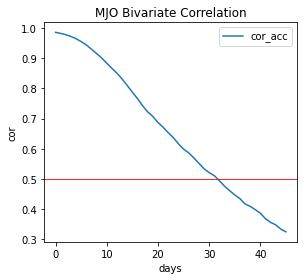

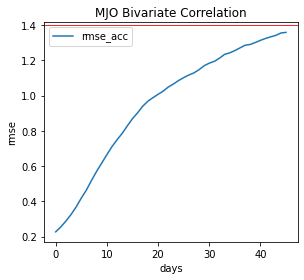

In [17]:
ecmf_cor_day=cor_caluate(ecmf_data,ecmf_re_data,46)
ecmf_rmse_day=rmse_caluate(ecmf_data,ecmf_re_data,46)
cor_acc(ecmf_cor_day)
rmse_acc(ecmf_rmse_day)